In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


In [2]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


In [3]:
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    resaved_file_name = 'resaved_image.jpg'    
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    ela_image = ImageChops.difference(original_image,resaved_image)
    
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 255 / max_difference
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [4]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0        

In [5]:
X = []
Y = []

In [6]:

path = '../Datasets/CASIA_FIDAC/Au/'      
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
        try:
            full_path = os.path.join(path, filename)
            X.append(prepare_image(full_path))        
            Y.append(1)     
        except:
            pass

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/1389 [00:00<?, ?it/s]

Total images: 1338
Total labels: 1338


In [7]:

path = '../Datasets/CASIA_FIDAC/Tp/'      
i=0
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
            i+=1
            try:
                full_path = os.path.join(path, filename)
                X.append(prepare_image(full_path))        
                Y.append(0)    
            except:
                pass

   
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/597 [00:00<?, ?it/s]

Total images: 1935
Total labels: 1935


In [8]:
from sklearn.utils import shuffle



In [9]:
X = np.array(X)
Y = np.array(Y)
X,Y= shuffle(X,Y)

X = X.reshape(-1, 128, 128, 3)



np.save('proposed_fidac_500_x.npy', X, allow_pickle=True)
np.save('proposed_fidac_500_y.npy', Y, allow_pickle=True)


In [10]:
X = np.load('proposed_fidac_500_x.npy', allow_pickle=True)
Y = np.load('proposed_fidac_500_y.npy', allow_pickle=True)

print(np.shape(X),np.shape(Y))

(1935, 128, 128, 3) (1935,)


In [11]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 1470 , Training labels: 1470
Validation images: 368 , Validation labels: 368
Test images: 97 , Test labels: 97


In [12]:
print(Y_test)

[1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1
 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1]


In [13]:
train_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    #zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)
test_gen =  ImageDataGenerator()

train_gen.fit(X_train)
test_gen.fit(X_val)

augmented_data = []


In [14]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(256, (3,3), activation = 'relu'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding = "SAME"))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0

In [16]:
epochs = 50
batch_size = 19


In [17]:
init_lr = 1e-4  
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [19]:
hist = model.fit(train_gen.flow(X_train, Y_train, batch_size=19),
                 batch_size = batch_size,
                 epochs = epochs,
                 #steps_per_epoch = 14,
                 validation_data = train_gen.flow(X_train, Y_train, batch_size=19))
                 #callbacks = [early_stopping])

Epoch 1/50
78/78 [==============================] - 51s 633ms/step - loss: 0.6156 - accuracy: 0.6837 - val_loss: 0.5636 - val_accuracy: 0.6905
Epoch 2/50
78/78 [==============================] - 44s 562ms/step - loss: 0.5448 - accuracy: 0.7007 - val_loss: 0.4963 - val_accuracy: 0.7980
Epoch 3/50
78/78 [==============================] - 46s 595ms/step - loss: 0.4917 - accuracy: 0.7891 - val_loss: 0.4278 - val_accuracy: 0.8177
Epoch 4/50
78/78 [==============================] - 52s 669ms/step - loss: 0.4594 - accuracy: 0.8027 - val_loss: 0.4255 - val_accuracy: 0.8129
Epoch 5/50
78/78 [==============================] - 51s 649ms/step - loss: 0.4447 - accuracy: 0.8075 - val_loss: 0.4012 - val_accuracy: 0.8177
Epoch 6/50
78/78 [==============================] - 52s 674ms/step - loss: 0.4334 - accuracy: 0.8163 - val_loss: 0.4141 - val_accuracy: 0.8252
Epoch 7/50
78/78 [==============================] - 52s 661ms/step - loss: 0.4219 - accuracy: 0.8170 - val_loss: 0.3951 - val_accuracy: 0.8252

In [20]:
model.save('ela_casia.h5') 

history_dict = hist.history
json.dump(history_dict, open('model_history', 'w'))

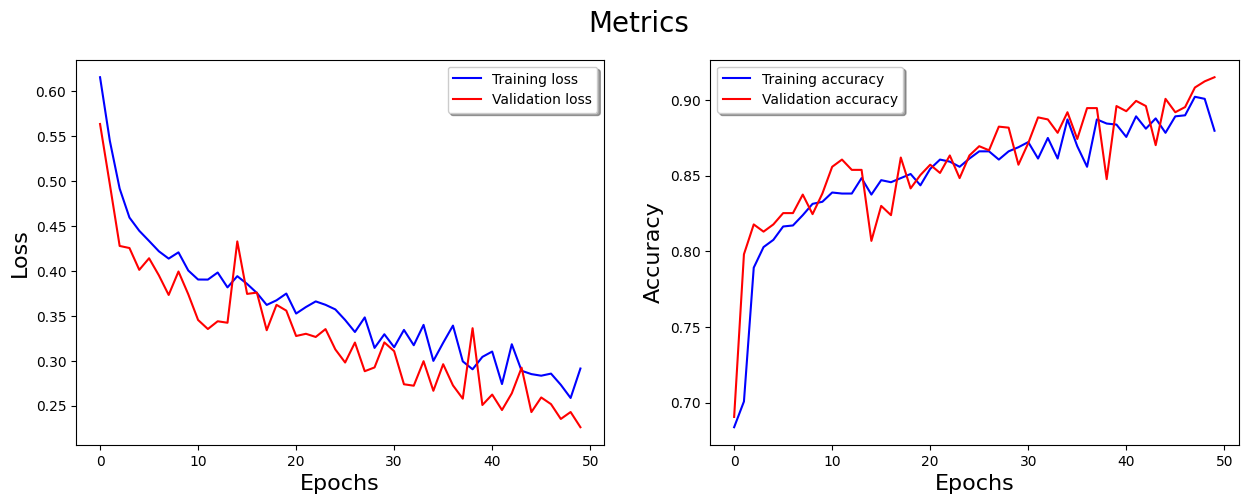

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss",axes =ax[0])
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20);

In [22]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

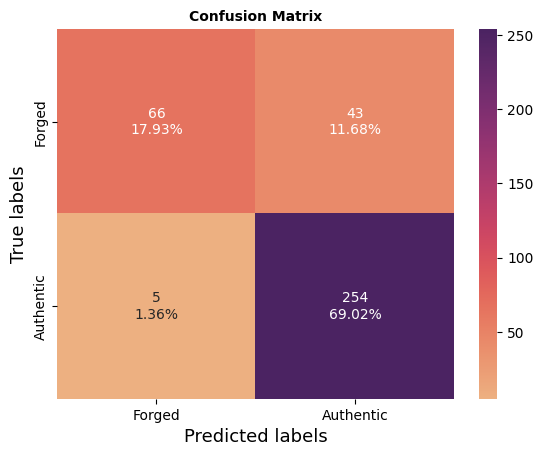

In [23]:
Y_pred = model.predict(X_val)              
Y_pred_classes = np.round(Y_pred)           
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     
plot_confusion_matrix(confusion_mtx)                         


In [24]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.61      0.73       109
           1       0.86      0.98      0.91       259

    accuracy                           0.87       368
   macro avg       0.89      0.79      0.82       368
weighted avg       0.88      0.87      0.86       368



In [25]:
class_names = ['Forged', 'Authentic']

In [26]:
correct_test = 0
total_test = 0  

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: 
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/97 [00:00<?, ?it/s]

Total test images: 97
Correctly predicted images: 75
Accuracy: 77.31958762886599 %


In [27]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [28]:
fake_image = '../Datasets/TEST/Tp/'
correct = 0
total = 0
for file_name in os.listdir(fake_image):
    if file_name.endswith('jpg') or file_name.endswith('png'):
        test_image_path = os.path.join(fake_image, file_name)
        test_image = prepare_image(test_image_path)  
        test_image=test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(test_image)
        y_pred_class = round(y_pred[0][0])
        total += 1
        if y_pred_class == 0:
            correct += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Class: Forged Confidence: 0.86
Class: Forged Confidence: 0.00
Class: Forged Confidence: 6.47
Class: Forged Confidence: 18.38
Class: Forged Confidence: 0.78
Class: Forged Confidence: 34.04
Class: Forged Confidence: 16.10
Class: Forged Confidence: 0.46
Class: Forged Confidence: 13.41
Class: Forged Confidence: 48.36
Class: Forged Confidence: 0.10
Class: Forged Confidence: 1.77
Class: Forged Confidence: 1.84
Class: Forged Confidence: 6.95
Class: Forged Confidence: 2.18
Class: Forged Confidence: 27.34
Class: Forged Confidence: 6.51
Class: Forged Confidence: 2.43
Class: Forged Confidence: 7.36
Class: Forged Confidence: 16.88
Class: Forged Confidence: 27.99
Class: Forged Confidence: 0.08
Class: Forged Confidence: 1.50
Class: Forged Confidence: 0.35
Class: Forged Confidence: 41.21
Class: Forged Confidence: 23.86
Class: Forged Confidence: 0.02
Class: Forged Confidence: 27.91
Class: Forged Confidence: 0.03
Class: Forged Confidence: 0.03
Class: Forged Confidence: 13.88
Class: Forged Confidence: 0

In [29]:
real_image = '../Datasets/Test/Au/'
correct_r = 0
total_r = 0
for file_name in os.listdir(real_image):
    if file_name.endswith('jpg') or file_name.endswith('png'):
        test_image_path = os.path.join(real_image, file_name)
        test_image = prepare_image(test_image_path)  
        test_image=test_image.reshape(-1, 128, 128, 3) 
        y_pred = model.predict(test_image)
        y_pred_class = round(y_pred[0][0])
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Class: Authentic Confidence: 51.90
Class: Authentic Confidence: 85.07
Class: Authentic Confidence: 99.89
Class: Authentic Confidence: 99.97
Class: Authentic Confidence: 99.47
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.91
Class: Authentic Confidence: 99.93
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.97
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.88
Class: Authentic Confidence: 99.65
Class: Authentic Confidence: 89.73
Class: Authentic Confidence: 98.66
Class: Authentic Confidence: 98.24
Class: Authentic Confidence: 96.40
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.92
Class: Authentic Confidence: 97.70
Class: Authentic Confidence: 97.64
Class: Authentic Confidence: 98.44
Class: Authentic Confidence: 99.96
Class: Authentic Confidence: 99.92
Class: Authentic Confidence: 99.99
Class: Authentic Confidence: 99.84
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.98
Class: Authenti

In [30]:
correct += correct_r
total += total_r
#print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 90, Correct: 75, Acc: 83.33333333333334


In [ ]:
# test_image_path = '../casia2/test/1.JPG'    # test image path
# test_image = prepare_image(test_image_path)
# test_image = test_image.reshape(-1, 128, 128, 3)

# y_pred = model.predict(test_image)
# y_pred_class = int(round(y_pred[0][0]))

# fig, ax = plt.subplots(1,2,figsize=(15,5)) 

# original_image = plt.imread(test_image_path) 
# ax[0].axis('off')
# ax[0].imshow(original_image)
# ax[0].set_title('Original Image')

# ax[1].axis('off')
# ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
# ax[1].set_title('ELA Image')

# print(f'Prediction: {class_names[y_pred_class]}')
# if y_pred<=0.5:
#     print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
# else:
#     print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
# print('--------------------------------------------------------------------------------------------------------------')

In [ ]:
# test_folder_path = 'Datasets/FIDAC/Au/'        #dataset path
# authentic,forged,total = 0,0,0

# for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
#     #print(filename)
#     if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg') or filename.endswith('JPG'):
#         test_image_path = os.path.join(test_folder_path, filename)
#         test_image = prepare_image(test_image_path)  
#         test_image=test_image.reshape(-1, 128, 128, 3)
#         #y_pred = model.predict(image)
#         #y_pred_class = np.round(y_pred)
        
#         y_pred = model.predict(test_image)
#         y_pred_class = round(y_pred[0][0])

#         total += 1
#         #print('---',y_pred_class)
#         if y_pred_class == 0:
#             forged += 1
#         else:
#             authentic +=1

# print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images :   0%|          | 0/14 [00:00<?, ?it/s]

Total images: 14
Authentic Images: 14
Forged Images: 0
